In [1]:
import cv2,os
import matplotlib.pyplot as plt
import numpy as np

img-path-list: ['n0101001-03-01.jpg', 'n0101001-03-02.jpg', 'n0101001-03-03.jpg']


[ WARN:0@0.662] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


len(good_l):4058


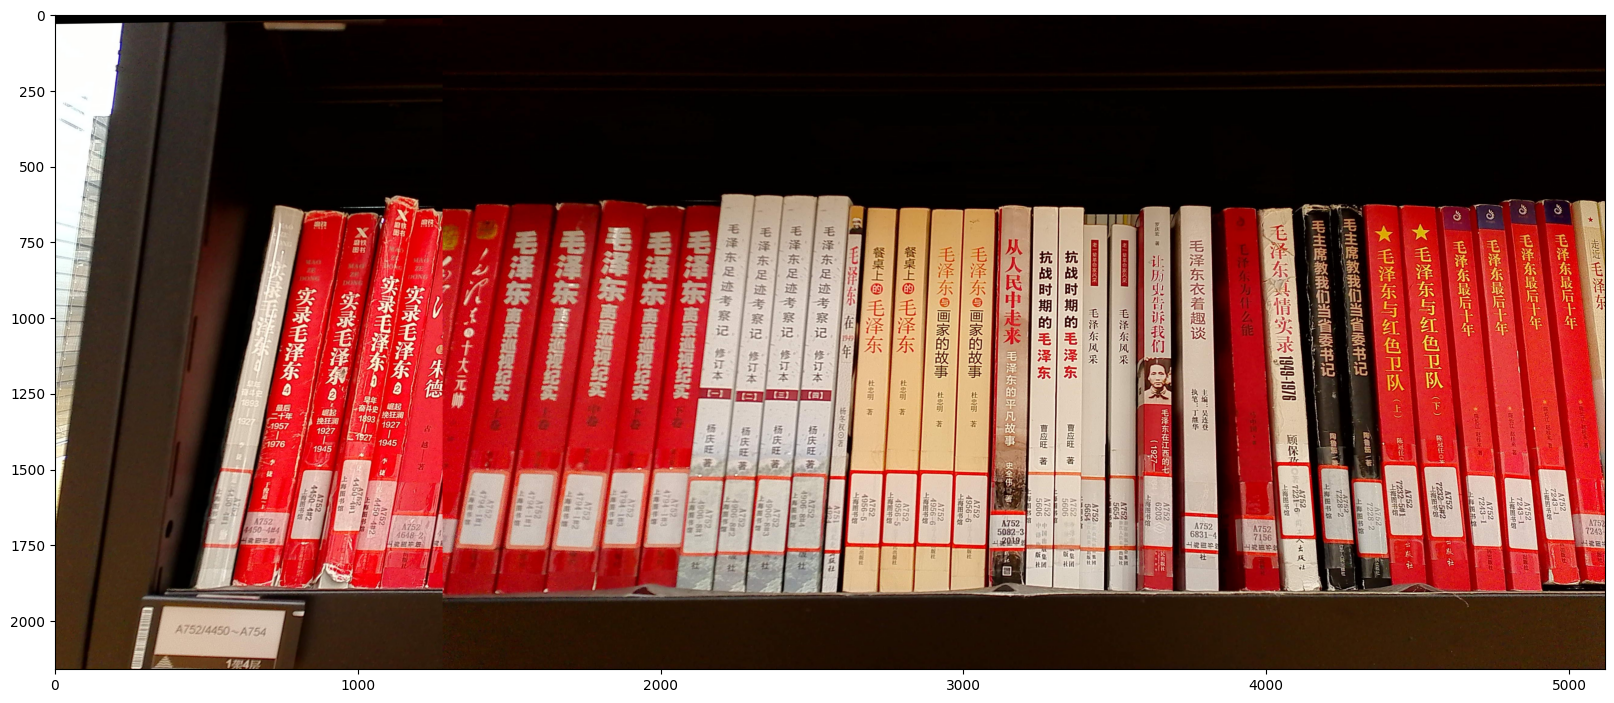

In [2]:
# %%writefile 基于opencv特征点检测的图像拼接.py
class stitcher:
    @staticmethod
    def detect(cv_im_bgr):
        # 转换为灰度图像
        cv_im_gray = cv2.cvtColor(cv_im_bgr, cv2.COLOR_BGR2GRAY)
        # sift = cv2.SIFI_create()
        sift = cv2.xfeatures2d.SIFT_create()
        kps, features = sift.detectAndCompute(cv_im_gray, None)
        return kps, features
    @staticmethod
    def match(src_cv_img, dst_cv_img):
        kps1, feats1 = stitcher.detect(src_cv_img)
        kps2, feats2 = stitcher.detect(dst_cv_img)
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        matches = matcher.knnMatch(feats1,  # 查询图像的特征描述符
                                   feats2,  # 训练图像（数据库图像）的特征描述符
                                   k=2)     # 查询图像的每个特征点要在训练图像中找到2个最佳匹配
        
        return kps1,kps2,matches  
    @staticmethod
    def match_keypoints(kps1,kps2,matches,ratio,threshold):
        
        # step1: 筛选匹配点
        good_l,matches_l = [], []
        for match in matches:
            #                            可见匹配的2个点还是有从 优秀-->次优秀排序的。 
            #                            如果ratio=0.8，那么对于一个（最优）匹配点，只有当它和它的下一个匹配点（次优）距离小于它的前一个匹配点距离的0.8倍时，才被保留。
            if len(match) == 2 and match[0].distance < match[1].distance * ratio:
                good_l.append(match[0])
                matches_l.append((match[0].queryIdx, match[0].trainIdx)) # （查询图像中点的索引，训练图像中点的索引）
        
        # 当匹配的特征点对数 > 4,就可以用来构建变换矩阵了
        
        kps1_coors = np.float32([kpt.pt for kpt in kps1]).tolist()
        kps2_coors = np.float32([kpt.pt for kpt in kps2]).tolist()
        print(f"len(good_l):{len(good_l)}")
        if len(good_l) > 4:
           match_kp1_l =  [kps1_coors[match[0]] for match in matches_l]
           match_kp2_l =  [kps2_coors[match[1]] for match in matches_l]
           # 计算变换矩阵(采用ransac算法从pts中选择一部分点) ==================> H作用：将原图像转换为目标图像
           H, status = cv2.findHomography(np.array(match_kp1_l), # 源图像上的点集
                                          np.array(match_kp2_l), # 目标图像上的点集
                                          cv2.RANSAC, threshold)
        
           return H,status, good_l
        return None,None,None
    
    @staticmethod
    def stitch(cv_im_bgr1, cv_im_bgr2, H, threshold=10):
        """
        cv_im_bgr1: 源图像， cv_im_bgr2: 目标图像， H: 源图像到目标图像的变换矩阵
        """
        # 获取图像尺寸
        src_h, src_w = cv_im_bgr1.shape[:2]
        dst_h, dst_w = cv_im_bgr2.shape[:2]
        # 对源图像做透视变换，由于透视变换会改变图像的尺寸，导致部分图像内容看不到，所以对图像进行扩展：
        # 高度取2图像中最高的，宽度为2者相加
        image = np.zeros((max(src_h, dst_h), src_w + dst_w + src_w , 3), dtype=np.uint8)
        image[:src_h, src_w//3:src_w+src_w//3]= cv_im_bgr1
        image = cv2.warpPerspective(image,
                                    H, 
                                    (image.shape[1], image.shape[0])) # 输出图像的尺寸，非图像内容区域用黑色像素填充
        image[0:dst_h, src_w//3:dst_w+src_w//3] = cv_im_bgr2
        
        ################################## 去掉黑边 begin######################################
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cols = gray.mean(axis=0)  # 计算每一列的平均像素值
        start_col = np.where(cols > threshold)[0][0]  # 找到第一个非黑边的列
        end_col = np.where(cols > threshold)[0][-1]   # 找到最后一个非黑边的列
        image = image[:, start_col:end_col]
        ################################## 去掉黑边 begin######################################
        return image
    
    @staticmethod
    def do(src_cv_im_bgr, dst_cv_im_bgr, ratio=0.8, threshold=3):
        kps1,kps2,matches =stitcher.match(src_cv_im_bgr, dst_cv_im_bgr)
        H,status, good = stitcher.match_keypoints(kps1,kps2,matches,ratio,threshold)
        if H is not None:
            return stitcher.stitch(src_cv_im_bgr, dst_cv_im_bgr, H)
        return None
#------------------------------------------------------------------------------------- 调用-------------------------------------------------------------------------------------
img_dir = r'./n0101001-03'

img_path_l = os.listdir(img_dir)
img_path_l = sorted(img_path_l,key=lambda a: int(a.split('-')[-1].replace('.jpg','').replace('.png','')))
print("img-path-list:",img_path_l)

im_l = [cv2.imread(os.path.join(img_dir,i)) for i in img_path_l]#[:2]
left_img = im_l[0]
other_im_l = im_l[1:]
# for im in other_im_l:
#     stitch_im = stitcher.do(left_img, im)
#     left_img = stitch_im
#     # break

stitch_im = stitcher.do(src_cv_im_bgr=im_l[0],dst_cv_im_bgr=im_l[1])
# stitch_im = stitcher.do(src_cv_im_bgr=im_l[2],dst_cv_im_bgr=stitch_im)
if stitch_im is not None:
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(stitch_im, cv2.COLOR_BGR2RGB))
    # cv2.imwrite(f'/mnt/disk3/projects/expore/accelerated_features/notebooks/results/stitch.jpg',stitch_im)
    plt.show()

In [ ]:
src_im = cv2.imread(img0_pth)
cv_im_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
# sift = cv2.SIFI_create()
sift = cv2.xfeatures2d.SIFT_create()
kps, features = sift.detectAndCompute(cv_im_gray, None)

NameError: name 'img0_pth' is not defined

In [ ]:
kps[:2], features[:2], len(kps), len(features)

In [ ]:
kps[0]

In [ ]:
kps[0].angle

In [18]:
kps[0].angle=90.12

In [ ]:
kps[0].angle

In [ ]:
size=1, angle=-1, response=1, octave=0, class_id=-1